<a href="https://colab.research.google.com/github/reshalfahsi/image-classification-augmentation/blob/master/Image_Classification_Using_Swin_Transformer_With_RandAugment_CutMix_and_MixUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification Using Swin Transformer With RandAugment, CutMix, and MixUp**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 249.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 283.5 MB/s eta 0:00:00


### **Import**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from google.colab.patches import cv2_imshow
from IPython.display import Image as ColabImage

from PIL import Image

from typing import Any, Callable, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data.dataloader import default_collate


from torchvision.ops import StochasticDepth, MLP, Permute
from torchvision.transforms import (
    Compose,
    RandAugment,
    ToTensor,
    Resize,
    Lambda
)
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import (
    download_url,
    download_and_extract_archive
)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [18]:
PATCH_SIZE            = [4, 4]
EMBED_DIM             = 96
DEPTHS                = [2, 2, 6, 2]
NUM_HEADS             = [3, 6, 12, 24]
WINDOW_SIZE           = [7, 7]
STOCHASTIC_DEPTH_PROB = 0.2

In [19]:
IMAGE_SIZE  = 224
NUM_CLASSES = 256

In [20]:
EPOCH      = 3 ** 2
BATCH_SIZE = 6 ** 2

In [21]:
TRUNCATE_PER_CATEGORY = int(1e4)

In [23]:
MOMENTUM = math.sqrt(6) / math.e
GOLDEN_RATIO = (1. + math.sqrt(5)) / 2.
EARLY_STOPPING_PATIENCE = 1 / 9

In [24]:
WEIGHT_DECAY  = GOLDEN_RATIO  * 10 ** -math.pi
LEARNING_RATE = GOLDEN_RATIO  * 10 ** -math.e

In [25]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [26]:
ACC_HISTORY     = dict()
LOSS_HISTORY    = dict()
MODEL_NAME      = dict()
MODEL           = dict()
BEST_MODEL_PATH = dict()

In [27]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [28]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1908429484


## **Dataset**

### **Utils**

In [29]:
AUG_TRANSFORM = Compose(
    [
        RandAugment(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [30]:
def AUG_COLLATE_FUNCTION(batch):
    return RandomChoice(
        [
            CutMix(num_classes=NUM_CLASSES),
            MixUp(num_classes=NUM_CLASSES),
        ]
    )(*default_collate(batch))

In [31]:
class Caltech256(VisionDataset):
    """`Caltech 256 <https://data.caltech.edu/records/20087>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``caltech256`` exists or will be saved to if download is set to
            True.
        split (string): dataset split
        transform (callable, optional): A function/transform that takes in a
            PIL image and returns a transformed version.
            E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        download (bool, optional): If true, downloads the dataset from the
            internet and puts it in root directory. If dataset is already
            downloaded, it is not downloaded again.
    """

    def __init__(
        self,
        root: str,
        split: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(
            os.path.join(root, "caltech256"),
            transform=transform,
            target_transform=target_transform,
        )
        os.makedirs(self.root, exist_ok=True)

        assert split in ["train", "val", "test", "inference"], (
            "Please choose one of these: 'train', 'val', 'test', or 'inference'"
        )

        if split == "inference":
            assert self.transform is None and self.target_transform is None

        self.split = split

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted. You can use download=True"
                "to download it"
            )

        self.categories = sorted(
            os.listdir(os.path.join(self.root, "256_ObjectCategories"))
        )

        self.y: List[int] = list()
        self.x = list()
        for i, c in enumerate(self.categories):
            if i == NUM_CLASSES: break

            image_path = [
                os.path.join(
                    self.root,
                    "256_ObjectCategories",
                    c,
                    item,
                )
                for item in os.listdir(
                    os.path.join(self.root, "256_ObjectCategories", c)
                )
                if item.endswith(".jpg")
            ]
            image_path = image_path[:TRUNCATE_PER_CATEGORY]

            start = 0
            end = 0

            if self.split == "train":
                end = int(0.81 * len(image_path))
            elif self.split == "val":
                start = int(0.81 * len(image_path))
                end = int(0.9 * len(image_path))
            else:
                start = int(0.9 * len(image_path))
                end = len(image_path)

            image_path = image_path[start:end]

            self.x.extend(image_path)
            self.y.extend(len(image_path) * [i])

        self.categories = [
            cat.split(".")[-1].replace("-101", "")
            for idx, cat in enumerate(self.categories)
            if idx < NUM_CLASSES
        ]

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img = Image.open(self.x[index]).convert('RGB')

        target = self.y[index]

        if self.split != "inference":
            if self.transform is not None:
                img = self.transform(img)

            if self.target_transform is not None:
                target = self.target_transform(target)

        return img, target

    def _check_integrity(self) -> bool:
        # can be more robust and check hash of files
        return os.path.exists(os.path.join(self.root, "256_ObjectCategories"))

    def __len__(self) -> int:
        # return len(self.index)
        return len(self.y)

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        filename = "256_ObjectCategories.tar"
        dataset_url = (
            f"https://data.caltech.edu/records/nyy15-4j048/files/{filename}"
        )

        download_and_extract_archive(
            dataset_url,
            self.root,
            filename=filename,
        )

### **Load**

In [32]:
TrainDataset = Caltech256(
    root='experiment/dataset/',
    split='train',
    transform=TRANSFORM,
    download=True,
)

TrainAugDataset = Caltech256(
    root='experiment/dataset/',
    split='train',
    transform=AUG_TRANSFORM,
    download=True,
)

ValDataset = Caltech256(
    root='experiment/dataset/',
    split='val',
    transform=TRANSFORM,
    download=True,
)

TestDataset = Caltech256(
    root='experiment/dataset/',
    split='test',
    transform=TRANSFORM,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### **Data Distribution**

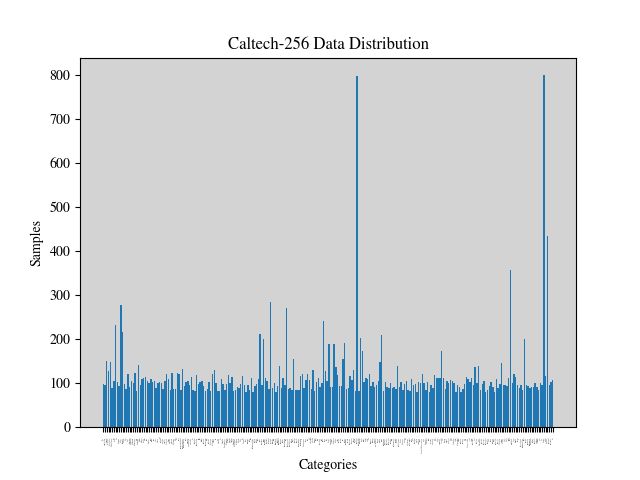

<Figure size 640x480 with 0 Axes>

In [45]:
def visualize_distribution():
    root = "experiment/dataset/caltech256"
    num_samples = list()
    categories = sorted(
        os.listdir(
            os.path.join(
                root,
                "256_ObjectCategories",
            )
        )
    )
    for i, c in enumerate(categories):
        if i == NUM_CLASSES: break
        n = len(
            [
                item
                for item in os.listdir(
                    os.path.join(root, "256_ObjectCategories", c)
                )
                if item.endswith(".jpg")
            ]
        )
        num_samples.append(n)
    categories = [
        cat.split(".")[-1].replace("-101", "")
        for idx, cat in enumerate(categories)
        if idx < NUM_CLASSES
    ]
    # Create bar plot
    plt.bar(categories, num_samples)

    # Customize labels and title
    plt.xlabel('Categories')
    plt.ylabel('Samples')
    plt.title('Caltech-256 Data Distribution')

    plt.xticks(fontsize=1, rotation=90)

    img_path = "experiment/dataset/data_distribution.png"

    plt.savefig(img_path)
    plt.clf()
    img = cv2.imread(img_path)
    cv2_imshow(img)

visualize_distribution()

## **Model**

### **Utils**

In [46]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Swin Transformer**

#### **Module**

In [47]:
def _patch_merging_pad(x: torch.Tensor) -> torch.Tensor:
    H, W, _ = x.shape[-3:]
    x = F.pad(x, (0, 0, 0, W % 2, 0, H % 2))
    x0 = x[..., 0::2, 0::2, :]  # ... H/2 W/2 C
    x1 = x[..., 1::2, 0::2, :]  # ... H/2 W/2 C
    x2 = x[..., 0::2, 1::2, :]  # ... H/2 W/2 C
    x3 = x[..., 1::2, 1::2, :]  # ... H/2 W/2 C
    x = torch.cat([x0, x1, x2, x3], -1)  # ... H/2 W/2 4*C
    return x

In [48]:
def _get_relative_position_bias(
    relative_position_bias_table: torch.Tensor,
    relative_position_index: torch.Tensor,
    window_size: List[int],
) -> torch.Tensor:
    N = window_size[0] * window_size[1]
    relative_position_bias = relative_position_bias_table[
        relative_position_index
    ]
    relative_position_bias = relative_position_bias.view(N, N, -1)
    relative_position_bias = (
        relative_position_bias.permute(2, 0, 1).contiguous().unsqueeze(0)
    )
    return relative_position_bias

In [49]:
class PatchMerging(nn.Module):
    """Patch Merging Layer.
    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
    """

    def __init__(
        self,
        dim: int,
        norm_layer: Callable[..., nn.Module] = nn.LayerNorm,
    ):
        super().__init__()

        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x: torch.Tensor):
        """
        Args:
            x (Tensor): input tensor with expected layout of [..., H, W, C]
        Returns:
            Tensor with layout of [..., H/2, W/2, 2*C]
        """
        x = _patch_merging_pad(x)
        x = self.norm(x)
        x = self.reduction(x)  # ... H/2 W/2 2*C
        return x

In [50]:
def shifted_window_attention(
    input: torch.Tensor,
    qkv_weight: torch.Tensor,
    proj_weight: torch.Tensor,
    relative_position_bias: torch.Tensor,
    window_size: List[int],
    num_heads: int,
    shift_size: List[int],
    qkv_bias: Optional[torch.Tensor] = None,
    proj_bias: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Window based multi-head self attention (W-MSA) module with relative position
    bias. It supports both of shifted and non-shifted window.
    Args:
        input (Tensor[N, H, W, C]): The input tensor or 4-dimensions.
        qkv_weight (Tensor[in_dim, out_dim]): The weight tensor of query,
                                              key, value.
        proj_weight (Tensor[out_dim, out_dim]): The weight tensor of projection.
        relative_position_bias (Tensor): The learned relative position
                                         bias added to attention.
        window_size (List[int]): Window size.
        num_heads (int): Number of attention heads.
        shift_size (List[int]): Shift size for shifted window attention.
        qkv_bias (Tensor[out_dim], optional): The bias tensor of query, key,
                                              value. Default: None.
        proj_bias (Tensor[out_dim], optional): The bias tensor of projection.
                                               Default: None.
    Returns:
        Tensor[N, H, W, C]: The output tensor after shifted window attention.
    """
    B, H, W, C = input.shape
    # pad feature maps to multiples of window size
    pad_r = (window_size[1] - W % window_size[1]) % window_size[1]
    pad_b = (window_size[0] - H % window_size[0]) % window_size[0]
    x = F.pad(input, (0, 0, 0, pad_r, 0, pad_b))
    _, pad_H, pad_W, _ = x.shape

    shift_size = shift_size.copy()
    # If window size is larger than feature size, there is no need to
    # shift window
    if window_size[0] >= pad_H:
        shift_size[0] = 0
    if window_size[1] >= pad_W:
        shift_size[1] = 0

    # cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))

    # partition windows
    num_windows = (pad_H // window_size[0]) * (pad_W // window_size[1])
    x = x.view(
        B,
        pad_H // window_size[0],
        window_size[0],
        pad_W // window_size[1],
        window_size[1],
        C,
    )
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(
        B * num_windows, window_size[0] * window_size[1], C
    )  # B*nW, Ws*Ws, C

    # multi-head attention
    qkv = F.linear(x, qkv_weight, qkv_bias)
    qkv = qkv.reshape(
        x.size(0), x.size(1), 3, num_heads, C // num_heads
    ).permute(
        2, 0, 3, 1, 4
    )
    q, k, v = qkv[0], qkv[1], qkv[2]
    q = q * (C // num_heads) ** -0.5
    attn = q.matmul(k.transpose(-2, -1))

    # add relative position bias
    attn = attn + relative_position_bias

    if sum(shift_size) > 0:
        # generate attention mask
        attn_mask = x.new_zeros((pad_H, pad_W))
        h_slices = (
            (0, -window_size[0]),
            (-window_size[0], -shift_size[0]),
            (-shift_size[0], None),
        )
        w_slices = (
            (0, -window_size[1]),
            (-window_size[1], -shift_size[1]),
            (-shift_size[1], None),
        )
        count = 0
        for h in h_slices:
            for w in w_slices:
                attn_mask[h[0] : h[1], w[0] : w[1]] = count
                count += 1
        attn_mask = attn_mask.view(
            pad_H // window_size[0],
            window_size[0],
            pad_W // window_size[1],
            window_size[1],
        )
        attn_mask = attn_mask.permute(0, 2, 1, 3).reshape(
            num_windows, window_size[0] * window_size[1]
        )
        attn_mask = attn_mask.unsqueeze(1) - attn_mask.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(
            attn_mask != 0, float(-100.0)
        ).masked_fill(
            attn_mask == 0, float(0.0)
        )
        attn = attn.view(
            x.size(0) // num_windows,
            num_windows,
            num_heads,
            x.size(1),
            x.size(1),
        )
        attn = attn + attn_mask.unsqueeze(1).unsqueeze(0)
        attn = attn.view(-1, num_heads, x.size(1), x.size(1))

    attn = F.softmax(attn, dim=-1)

    x = attn.matmul(v).transpose(1, 2).reshape(x.size(0), x.size(1), C)
    x = F.linear(x, proj_weight, proj_bias)

    # reverse windows
    x = x.view(
        B,
        pad_H // window_size[0],
        pad_W // window_size[1],
        window_size[0],
        window_size[1],
        C,
    )
    x = x.permute(0, 1, 3, 2, 4, 5).reshape(B, pad_H, pad_W, C)

    # reverse cyclic shift
    if sum(shift_size) > 0:
        x = torch.roll(x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))

    # unpad features
    x = x[:, :H, :W, :].contiguous()
    return x

In [51]:
class ShiftedWindowAttention(nn.Module):
    """
    See :func:`shifted_window_attention`.
    """

    def __init__(
        self,
        dim: int,
        window_size: List[int],
        shift_size: List[int],
        num_heads: int,
        qkv_bias: bool = True,
        proj_bias: bool = True,
    ):
        super().__init__()
        if len(window_size) != 2 or len(shift_size) != 2:
            raise ValueError("window_size and shift_size must be of length 2")
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim, bias=proj_bias)

        self.define_relative_position_bias_table()
        self.define_relative_position_index()

    def define_relative_position_bias_table(self):
        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            )
        )  # 2*Wh-1 * 2*Ww-1, nH
        nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)

    def define_relative_position_index(self):
        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(
            torch.meshgrid(coords_h, coords_w, indexing="ij")
        )  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        # shift to start from 0
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        # Wh*Ww*Wh*Ww
        relative_position_index = relative_coords.sum(-1).flatten()
        self.register_buffer("relative_position_index", relative_position_index)

    def get_relative_position_bias(self) -> torch.Tensor:
        return _get_relative_position_bias(
            self.relative_position_bias_table,
            self.relative_position_index,
            self.window_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (Tensor): Tensor with layout of [B, H, W, C]
        Returns:
            Tensor with same layout as input, i.e. [B, H, W, C]
        """
        relative_position_bias = self.get_relative_position_bias()
        return shifted_window_attention(
            x,
            self.qkv.weight,
            self.proj.weight,
            relative_position_bias,
            self.window_size,
            self.num_heads,
            shift_size=self.shift_size,
            qkv_bias=self.qkv.bias,
            proj_bias=self.proj.bias,
        )

In [52]:
class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (List[int]): Window size.
        shift_size (List[int]): Shift size for shifted window attention.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
                           Default: 4.0.
        stochastic_depth_prob: (float): Stochastic depth rate. Default: 0.0.
        norm_layer (nn.Module): Normalization layer.  Default: nn.LayerNorm.
        attn_layer (nn.Module): Attention layer. Default: ShiftedWindowAttention
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: List[int],
        shift_size: List[int],
        mlp_ratio: float = 4.0,
        stochastic_depth_prob: float = 0.0,
        norm_layer: Callable[..., nn.Module] = nn.LayerNorm,
        attn_layer: Callable[..., nn.Module] = ShiftedWindowAttention,
    ):
        super().__init__()

        self.norm1 = norm_layer(dim)
        self.attn = attn_layer(
            dim,
            window_size,
            shift_size,
            num_heads,
        )
        self.stochastic_depth = StochasticDepth(
            stochastic_depth_prob,
            "row",
        )
        self.norm2 = norm_layer(dim)
        self.mlp = MLP(
            dim,
            [int(dim * mlp_ratio), dim],
            activation_layer=nn.GELU,
            inplace=None,
        )

        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def forward(self, x: torch.Tensor):
        x = x + self.stochastic_depth(self.attn(self.norm1(x)))
        x = x + self.stochastic_depth(self.mlp(self.norm2(x)))
        return x

In [53]:
class SwinTransformer(nn.Module):
    """
    Implements Swin Transformer from the `"Swin Transformer:
    Hierarchical Vision Transformer using Shifted Windows"
    <https://arxiv.org/abs/2103.14030>`_ paper.
    Args:
        patch_size (List[int]): Patch size.
        embed_dim (int): Patch embedding dimension.
        depths (List(int)): Depth of each Swin Transformer layer.
        num_heads (List(int)): Number of attention heads in different layers.
        window_size (List[int]): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
                           Default: 4.0.
        stochastic_depth_prob (float): Stochastic depth rate. Default: 0.1.
        num_classes (int): Number of classes for classification head.
                           Default: NUM_CLASSES.
        block (nn.Module, optional): SwinTransformer Block. Default: None.
        norm_layer (nn.Module, optional): Normalization layer. Default: None.
        downsample_layer (nn.Module): Downsample layer (patch merging).
                                      Default: PatchMerging.
    """

    def __init__(
        self,
        patch_size: List[int],
        embed_dim: int,
        depths: List[int],
        num_heads: List[int],
        window_size: List[int],
        mlp_ratio: float = 4.0,
        stochastic_depth_prob: float = 0.1,
        num_classes: int = NUM_CLASSES,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        block: Optional[Callable[..., nn.Module]] = None,
        downsample_layer: Callable[..., nn.Module] = PatchMerging,
    ):
        super().__init__()
        self.num_classes = num_classes

        if block is None:
            block = SwinTransformerBlock
        if norm_layer is None:
            norm_layer = partial(nn.LayerNorm, eps=1e-5)

        layers: List[nn.Module] = []
        # split image into non-overlapping patches
        layers.append(
            nn.Sequential(
                nn.Conv2d(
                    3,
                    embed_dim,
                    kernel_size=(patch_size[0], patch_size[1]),
                    stride=(patch_size[0], patch_size[1]),
                ),
                Permute([0, 2, 3, 1]),
                norm_layer(embed_dim),
            )
        )

        total_stage_blocks = sum(depths)
        stage_block_id = 0
        # build SwinTransformer blocks
        for i_stage in range(len(depths)):
            stage: List[nn.Module] = []
            dim = embed_dim * 2**i_stage
            for i_layer in range(depths[i_stage]):
                # adjust stochastic depth probability based on the depth of the
                # stage block
                sd_prob = (
                    stochastic_depth_prob
                    * float(stage_block_id)
                    / (total_stage_blocks - 1)
                )
                stage.append(
                    block(
                        dim,
                        num_heads[i_stage],
                        window_size=window_size,
                        shift_size=[
                            0
                            if i_layer % 2 == 0 else w // 2
                            for w in window_size
                        ],
                        mlp_ratio=mlp_ratio,
                        stochastic_depth_prob=sd_prob,
                        norm_layer=norm_layer,
                    )
                )
                stage_block_id += 1
            layers.append(nn.Sequential(*stage))
            # add patch merging layer
            if i_stage < (len(depths) - 1):
                layers.append(downsample_layer(dim, norm_layer))
        self.features = nn.Sequential(*layers)

        num_features = embed_dim * 2 ** (len(depths) - 1)
        self.norm = norm_layer(num_features)
        self.permute = Permute([0, 3, 1, 2])  # B H W C -> B C H W
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten(1)
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.norm(x)
        x = self.permute(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

#### **Get Model**

In [54]:
def _swin_transformer(
    patch_size: List[int],
    embed_dim: int,
    depths: List[int],
    num_heads: List[int],
    window_size: List[int],
    stochastic_depth_prob: float,
    pretrained: bool=True, # Cure to the imbalance dataset
) -> SwinTransformer:

    model = SwinTransformer(
        patch_size=patch_size,
        embed_dim=embed_dim,
        depths=depths,
        num_heads=num_heads,
        window_size=window_size,
        stochastic_depth_prob=stochastic_depth_prob,
    )

    if pretrained:
        download_url(
            url="https://download.pytorch.org/models/swin_t-704ceda3.pth",
            root="experiment/model",
            filename="swin_t-704ceda3.pth",
        )

        model.load_state_dict(
            torch.load("experiment/model/swin_t-704ceda3.pth"),
            strict=False,
        )

    return model

## **Without Augmentation**

### **Wrapper**

In [58]:
class NoAugmentation(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.arch = _swin_transformer(
            patch_size=PATCH_SIZE,
            embed_dim=EMBED_DIM,
            depths=DEPTHS,
            num_heads=NUM_HEADS,
            window_size=WINDOW_SIZE,
            stochastic_depth_prob=STOCHASTIC_DEPTH_PROB,
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.test_accuracy_top5 = Accuracy(
            task="multiclass",
            top_k=5,
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

        sch = self.lr_schedulers()
        sch.step()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME['no_aug']}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)
        self.test_accuracy_top5.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc_top1",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc_top5",
            self.test_accuracy_top5.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME['no_aug']}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["no_aug"] = self.val_loss

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME['no_aug']}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["no_aug"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                self.max_epoch,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [59]:
MODEL["no_aug"] = NoAugmentation
MODEL_NAME["no_aug"] = MODEL["no_aug"].__name__
BEST_MODEL_PATH["no_aug"] = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME['no_aug']}_best.ckpt",
)

### **Training**

INFO: Seed set to 1908429484
INFO:lightning.fabric.utilities.seed:Seed set to 1908429484


NoAugmentation


100%|██████████| 113445839/113445839 [00:00<00:00, 244810709.90it/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name               | Type               | Params
----------------------------------------------------------
0 | arch               | SwinTransformer    | 27.7 M
1 | train_accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy       | MulticlassAccuracy | 0     
3 | test_accuracy     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0030953218383568126 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.003001986464409091 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.002733237966147434 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0023214913787676095 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0018164094174400632 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0012789124209167497 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0007738304595892035 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 0.0003620838722093786 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[NoAugmentation] Learning Rate Changed: 9.333537394772185e-05 - Epoch: 8


INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


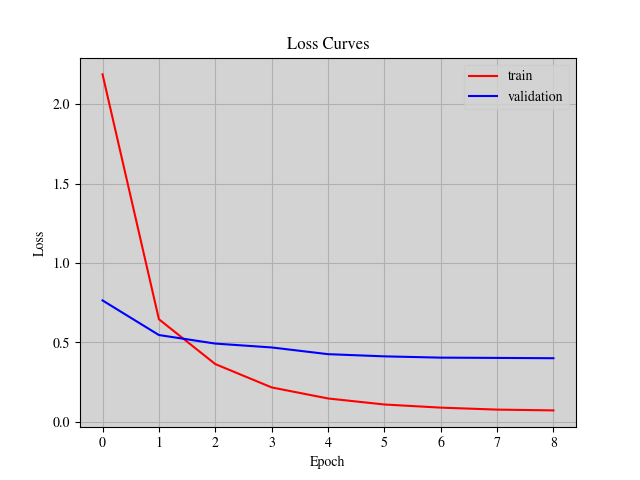

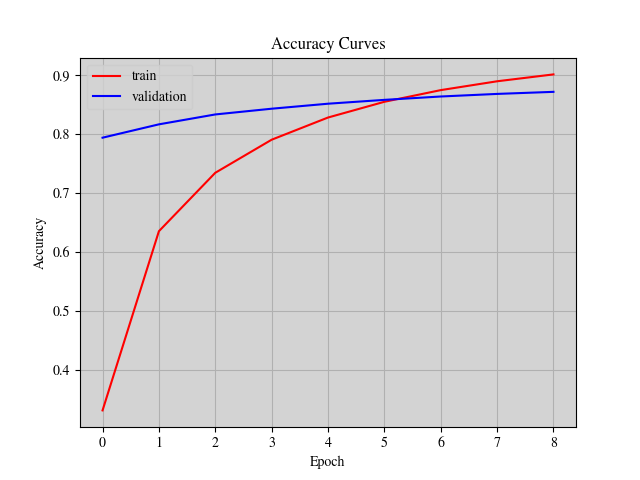

<Figure size 640x480 with 0 Axes>

In [60]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME['no_aug'])
    model = MODEL['no_aug']()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME['no_aug']}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH["no_aug"]):
        ckpt_path = BEST_MODEL_PATH["no_aug"]
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

### **Testing**

In [61]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL['no_aug']()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH['no_aug'])

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/NoAugmentation_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/NoAugmentation_best.ckpt


Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/NoAugmentation_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/NoAugmentation_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_top1       │    0.9016920328140259     │
│       test_acc_top5       │    0.9767813086509705     │
│         test_loss         │    0.36955755949020386    │
└───────────────────────────┴───────────────────────────┘

### **Inference**

Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth
Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

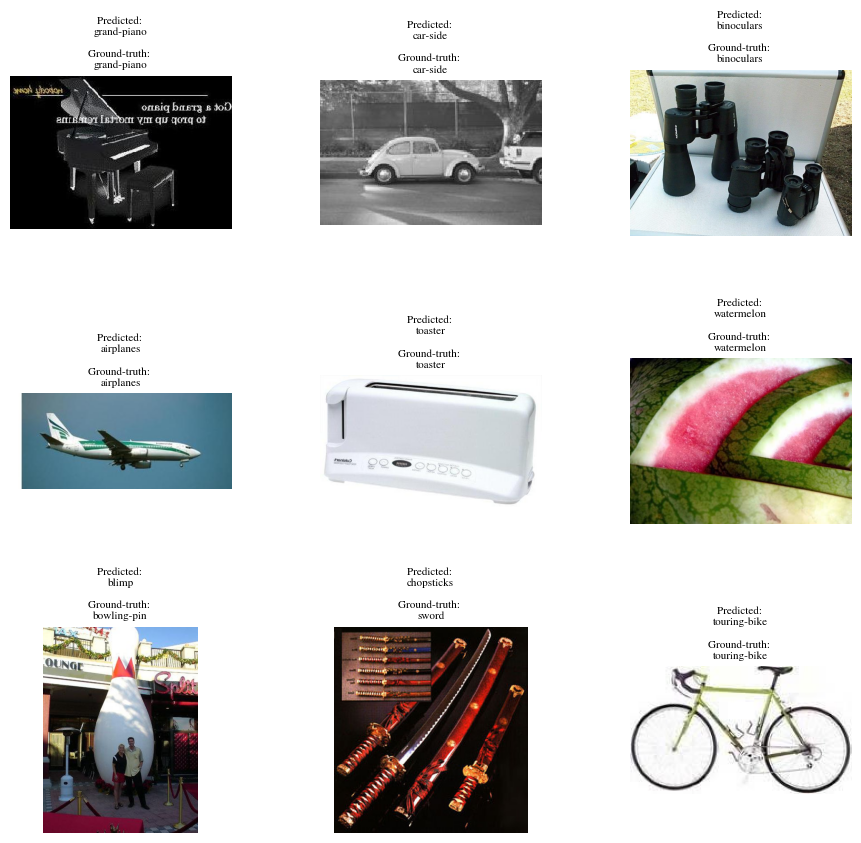

In [63]:
model = MODEL["no_aug"].load_from_checkpoint(BEST_MODEL_PATH["no_aug"])

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


InferenceDataset = Caltech256(
    root='experiment/dataset/',
    split='inference',
    download=True,
)


for index in range(9):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_idx = InferenceDataset[sample_idx]
        gt_class = InferenceDataset.categories[gt_idx]

        if not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    prediction = model(
        TRANSFORM(image).to(
            "cuda" if torch.cuda.is_available else "cpu"
        ).unsqueeze(0)
    )

    prediction.softmax(1)
    predicted_class = InferenceDataset.categories[
        torch.argmax(prediction).data.cpu().numpy()
    ]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{gt_class}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(image).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

del InferenceDataset

## **With Augmentation**

### **Wrapper**

In [64]:
class Augmentation(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.arch = _swin_transformer(
            patch_size=PATCH_SIZE,
            embed_dim=EMBED_DIM,
            depths=DEPTHS,
            num_heads=NUM_HEADS,
            window_size=WINDOW_SIZE,
            stochastic_depth_prob=STOCHASTIC_DEPTH_PROB,
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.test_accuracy_top5 = Accuracy(
            task="multiclass",
            top_k=5,
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch

        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(
            y_hat.softmax(1),
            torch.argmax(y.clone().detach().softmax(1), dim=1),
        )

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

        sch = self.lr_schedulers()
        sch.step()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME['aug']}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)
        self.test_accuracy_top5.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc_top1",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc_top5",
            self.test_accuracy_top5.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME['aug']}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["aug"] = self.val_loss

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME['aug']}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["aug"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainAugDataset,
            batch_size=self.batch_size,
            collate_fn=AUG_COLLATE_FUNCTION,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                self.max_epoch,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [65]:
MODEL["aug"] = Augmentation
MODEL_NAME["aug"] = MODEL["aug"].__name__
BEST_MODEL_PATH["aug"] = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME['aug']}_best.ckpt",
)

### **Training**

INFO: Seed set to 1908429484
INFO:lightning.fabric.utilities.seed:Seed set to 1908429484


Augmentation


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name               | Type               | Params
----------------------------------------------------------
0 | arch               | SwinTransformer    | 27.7 M
1 | train_accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy       | MulticlassAccuracy | 0     
3 | test_accuracy      | MulticlassAccuracy | 0     
4 | test_accuracy_top5 | MulticlassAcc

Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0030953218383568126 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.003001986464409091 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.002733237966147434 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0023214913787676095 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0018164094174400632 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0012789124209167497 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0007738304595892035 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 0.0003620838722093786 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[Augmentation] Learning Rate Changed: 9.333537394772185e-05 - Epoch: 8


INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


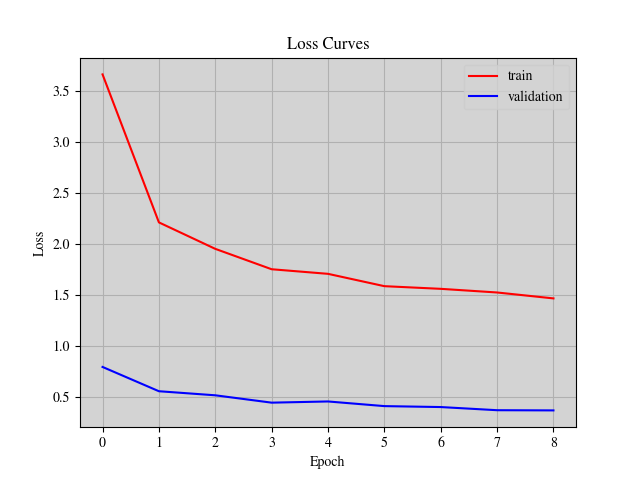

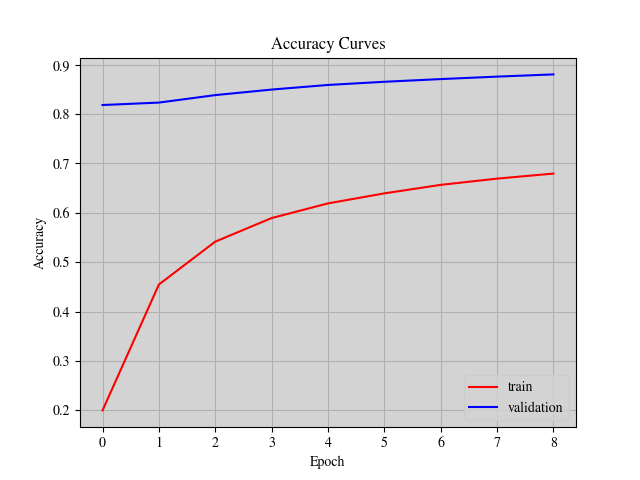

<Figure size 640x480 with 0 Axes>

In [66]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME['aug'])
    model = MODEL['aug']()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME['aug']}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH["aug"]):
        ckpt_path = BEST_MODEL_PATH["aug"]
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

### **Testing**

In [67]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL['aug']()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH['aug'])

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/Augmentation_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/Augmentation_best.ckpt


Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/Augmentation_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/Augmentation_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_top1       │    0.9157212972640991     │
│       test_acc_top5       │    0.9874842762947083     │
│         test_loss         │    0.3473457992076874     │
└───────────────────────────┴───────────────────────────┘

### **Inference**

Using downloaded and verified file: experiment/model/swin_t-704ceda3.pth
Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

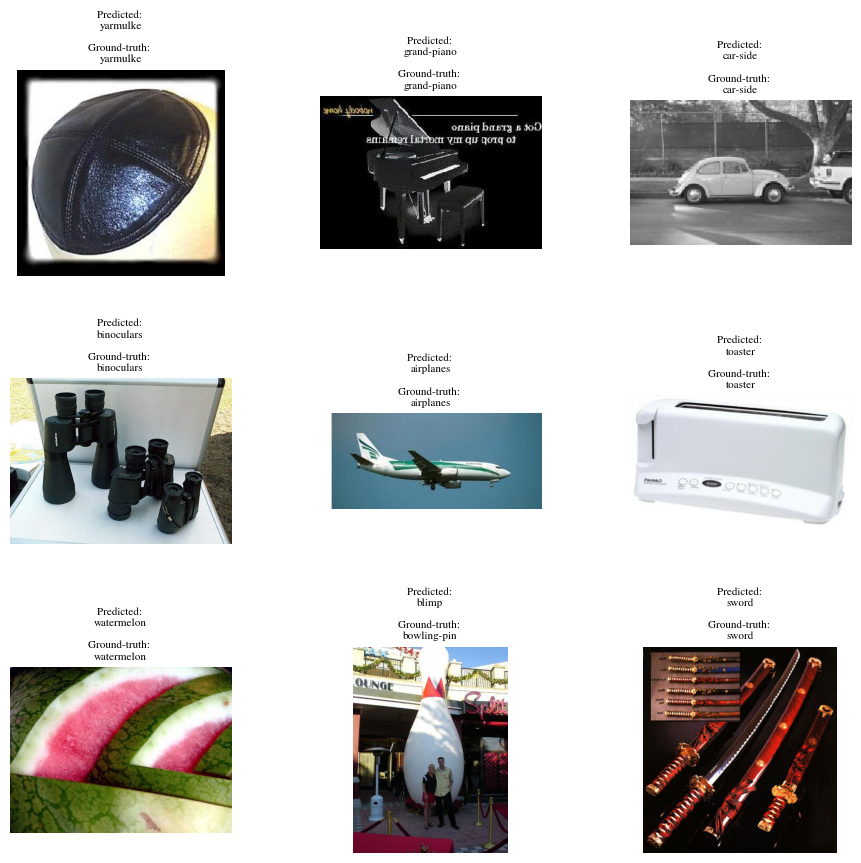

In [68]:
model = MODEL["aug"].load_from_checkpoint(BEST_MODEL_PATH["aug"])

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


InferenceDataset = Caltech256(
    root='experiment/dataset/',
    split='inference',
    download=True,
)


for index in range(9):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_idx = InferenceDataset[sample_idx]
        gt_class = InferenceDataset.categories[gt_idx]

        if not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    prediction = model(
        TRANSFORM(image).to(
            "cuda" if torch.cuda.is_available else "cpu"
        ).unsqueeze(0)
    )

    prediction.softmax(1)
    predicted_class = InferenceDataset.categories[
        torch.argmax(prediction).data.cpu().numpy()
    ]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{gt_class}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(image).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

del InferenceDataset

## **From Scratch**

### **Configure and Load**

In [69]:
'''
Truncating the dataset to forcefully make it equally distributed
'''
TRUNCATE_PER_CATEGORY = 10 ** 2

TrainDataset = Caltech256(
    root='experiment/dataset/',
    split='train',
    transform=TRANSFORM,
    download=True,
)

ValDataset = Caltech256(
    root='experiment/dataset/',
    split='val',
    transform=TRANSFORM,
    download=True,
)

TestDataset = Caltech256(
    root='experiment/dataset/',
    split='test',
    transform=TRANSFORM,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### **Wrapper**

In [70]:
class FromScratch(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.arch = _swin_transformer(
            patch_size=PATCH_SIZE,
            embed_dim=EMBED_DIM,
            depths=DEPTHS,
            num_heads=NUM_HEADS,
            window_size=WINDOW_SIZE,
            stochastic_depth_prob=STOCHASTIC_DEPTH_PROB,
            pretrained=False,
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )
        self.test_accuracy_top5 = Accuracy(
            task="multiclass",
            top_k=5,
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

        sch = self.lr_schedulers()
        sch.step()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME['scratch']}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)
        self.test_accuracy_top5.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc_top1",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_acc_top5",
            self.test_accuracy_top5.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME['scratch']}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        LOSS_HISTORY["scratch"] = self.val_loss

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME['scratch']}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

        ACC_HISTORY["scratch"] = self.val_acc

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                self.max_epoch,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [71]:
MODEL["scratch"] = FromScratch
MODEL_NAME["scratch"] = MODEL["scratch"].__name__
BEST_MODEL_PATH["scratch"] = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME['scratch']}_best.ckpt",
)

### **Training**

INFO: Seed set to 1908429484
INFO:lightning.fabric.utilities.seed:Seed set to 1908429484


FromScratch


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name               | Type               | Params
----------------------------------------------------------
0 | arch               | SwinTransformer    | 27.7 M
1 | train_accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy       | MulticlassAccuracy | 0     
3 | test_accuracy      | MulticlassAccuracy | 0     
4 | test_accuracy_top5 | MulticlassAcc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0030953218383568126 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.003001986464409091 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.002733237966147434 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0023214913787676095 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0018164094174400632 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0012789124209167497 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0007738304595892035 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 0.0003620838722093786 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[FromScratch] Learning Rate Changed: 9.333537394772185e-05 - Epoch: 8


INFO: `Trainer.fit` stopped: `max_epochs=9` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


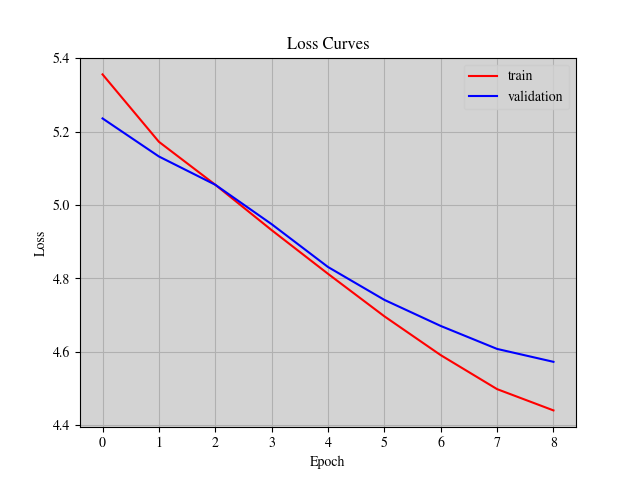

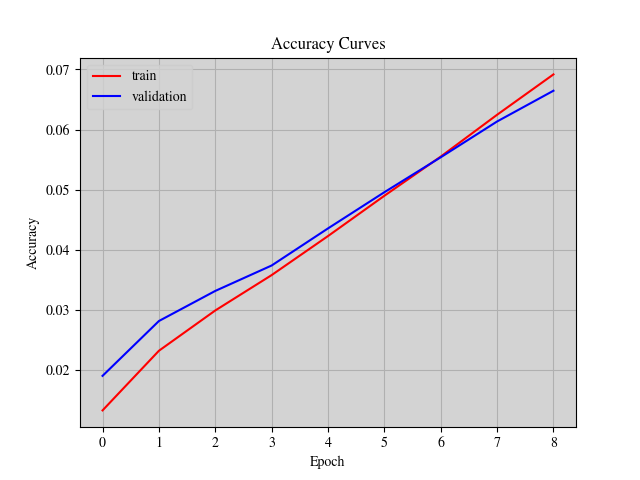

<Figure size 640x480 with 0 Axes>

In [72]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME['scratch'])
    model = MODEL['scratch']()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME['scratch']}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH["scratch"]):
        ckpt_path = BEST_MODEL_PATH["scratch"]
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

### **Testing**

In [73]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL['scratch']()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH['scratch'])

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/FromScratch_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/FromScratch_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/FromScratch_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_acc_top1       │    0.1158006489276886     │
│       test_acc_top5       │    0.2709672451019287     │
│         test_loss         │     4.54355001449585      │
└───────────────────────────┴───────────────────────────┘

### **Inference**

Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

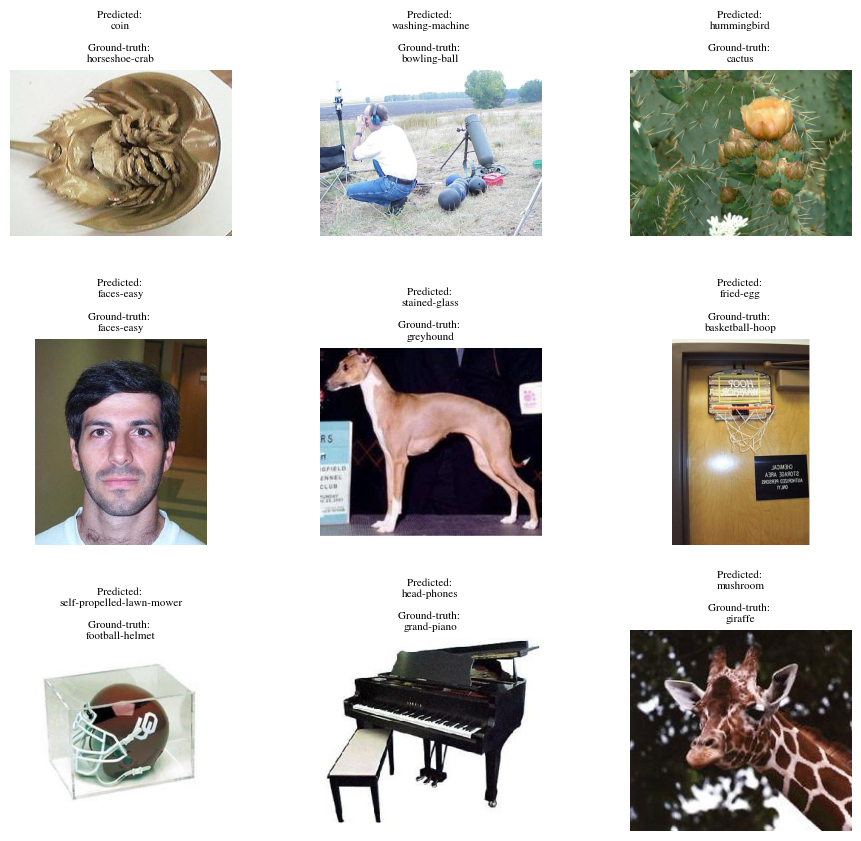

In [74]:
model = MODEL["scratch"].load_from_checkpoint(BEST_MODEL_PATH["scratch"])

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


InferenceDataset = Caltech256(
    root='experiment/dataset/',
    split='inference',
    download=True,
)


for index in range(9):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_idx = InferenceDataset[sample_idx]
        gt_class = InferenceDataset.categories[gt_idx]

        if not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    prediction = model(
        TRANSFORM(image).to(
            "cuda" if torch.cuda.is_available else "cpu"
        ).unsqueeze(0)
    )

    prediction.softmax(1)
    predicted_class = InferenceDataset.categories[
        torch.argmax(prediction).data.cpu().numpy()
    ]

    title = f"Predicted: \n{predicted_class}\n\n"
    title += f"Ground-truth: \n{gt_class}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(image).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

del InferenceDataset

## **Comparison**

### **Loss**

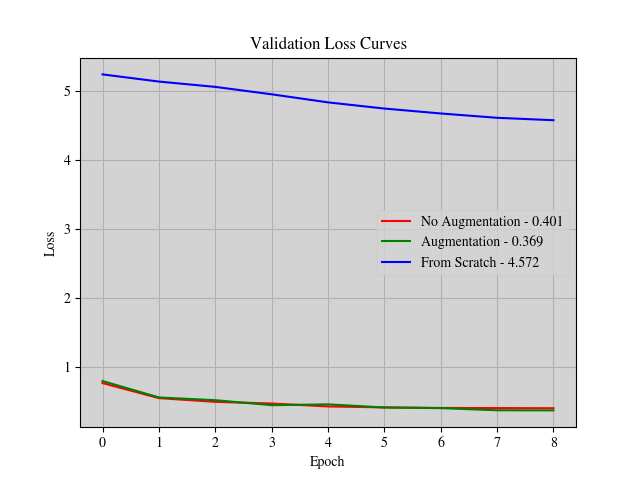

<Figure size 640x480 with 0 Axes>

In [75]:
loss_img_file = "experiment/loss_plot_comparison.png"
plt.plot(
    LOSS_HISTORY['no_aug'],
    color="r",
    label=f"No Augmentation - {round(LOSS_HISTORY['no_aug'][-1].tolist(), 3)}",
)
plt.plot(
    LOSS_HISTORY['aug'],
    color="g",
    label=f"Augmentation - {round(LOSS_HISTORY['aug'][-1].tolist(), 3)}",
)
plt.plot(
    LOSS_HISTORY['scratch'],
    color="b",
    label=f"From Scratch - {round(LOSS_HISTORY['scratch'][-1].tolist(), 3)}",
)
plt.title("Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(loss_img_file)
plt.clf()
img = cv2.imread(loss_img_file)
cv2_imshow(img)

### **Accuracy**

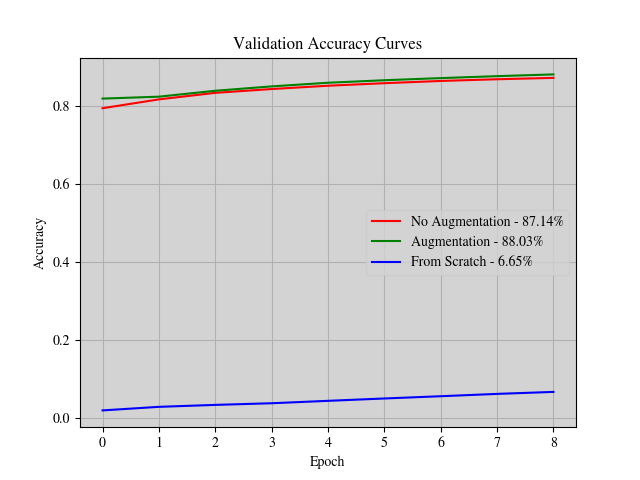

<Figure size 640x480 with 0 Axes>

In [76]:
acc_img_file = "experiment/acc_plot_comparison.png"
label_no_aug = "No Augmentation - "
label_no_aug += f"{round(ACC_HISTORY['no_aug'][-1].tolist() * 100., 2)}%"
plt.plot(
    ACC_HISTORY["no_aug"],
    color="r",
    label=label_no_aug,
)
plt.plot(
    ACC_HISTORY["aug"],
    color="g",
    label=f"Augmentation - {round(ACC_HISTORY['aug'][-1].tolist() * 100., 2)}%",
)
label_scratch = "From Scratch - "
label_scratch += f"{round(ACC_HISTORY['scratch'][-1].tolist() * 100., 2)}%"
plt.plot(
    ACC_HISTORY["scratch"],
    color="b",
    label=label_scratch,
)
plt.title("Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig(acc_img_file)
plt.clf()
img = cv2.imread(acc_img_file)
cv2_imshow(img)